### Imports

In [125]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import ray
from ray.train import ScalingConfig, RunConfig, FailureConfig
from ray.train.torch import TorchTrainer
from ray import tune
import os
import pickle
with open('pre-processed_data.pkl', 'rb') as f:
    data = pickle.load(f)
globals().update(data)

### SARIMA Model

In [33]:
model_sarima = pm.auto_arima(
    sarima_train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=508.699, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=506.093, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=507.224, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=505.236, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=506.197, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=507.895, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=510.601, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=508.786, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=507.078, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=507.270, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.903 seconds


In [35]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   38
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -250.618
Date:                            Fri, 02 May 2025   AIC                            505.236
Time:                                    13:43:40   BIC                            507.674
Sample:                                01-31-2015   HQIC                           505.913
                                     - 02-28-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2673      0.115     -2.330      0.020      -0.492      -0.042
sigma2      2.853e+07   2.91e-10   9.79e+16      0.000    2.85e+07    2.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.88   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.17   Prob(JB):                         0.64
Heteroskedasticity (H):               1.43   Skew:                            -0.01
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.52e+32. Standard errors may be unstable.
"""

In [37]:
sarima_pred = model_sarima.predict(n_periods=len(sarima_test))

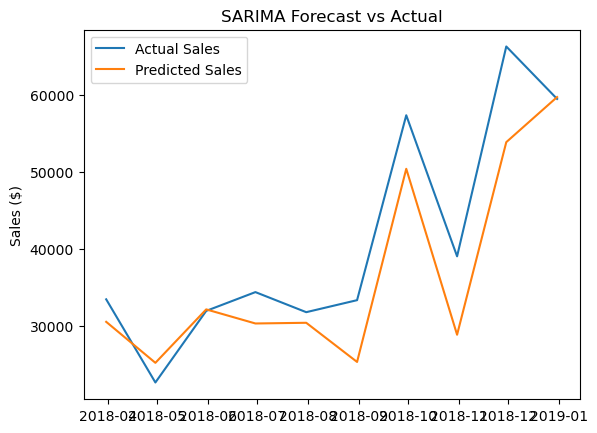

In [39]:
plt.plot(sarima_test.index, sarima_test, label='Actual Sales')
plt.plot(sarima_test.index, sarima_pred, label='Predicted Sales')
plt.ylabel('Sales ($)')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [57]:
sarima_test, sarima_pred

(Order Date
 2018-03-31    33470.2723
 2018-04-30    22668.2636
 2018-05-31    31967.5794
 2018-06-30    34408.2347
 2018-07-31    31800.9025
 2018-08-31    33361.6780
 2018-09-30    57381.9420
 2018-10-31    39056.8857
 2018-11-30    66318.1870
 2018-12-31    59504.4808
 Freq: ME, Name: Sales, dtype: float64,
 2018-03-31    30546.617846
 2018-04-30    25221.757294
 2018-05-31    32163.202860
 2018-06-30    30332.877265
 2018-07-31    30423.163400
 2018-08-31    25335.514452
 2018-09-30    50425.946396
 2018-10-31    28870.949289
 2018-11-30    53889.427642
 2018-12-31    59748.352024
 Freq: ME, dtype: float64)

In [41]:
rmse = root_mean_squared_error(sarima_test, sarima_pred)
mae = mean_absolute_error(sarima_test, sarima_pred)
mape = (abs((sarima_test - sarima_pred) / sarima_test)).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 6361.64
MAE: 4896.66
MAPE: 11.82%


### SARIMAX Model

In [43]:
X_train = sarimax_train.drop(columns='Sales')
y_train = sarimax_train['Sales']

X_test = sarimax_test.drop(columns='Sales')
y_test = sarimax_test['Sales']

In [83]:
model_sarimax = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,
    d=1,
    D=1,
    stepwise=True,
    suppress_warnings=True,
    trace=True
) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=308.710, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=311.479, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=312.504, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=310.267, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=310.279, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=312.279, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=309.723, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=310.775, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=312.435, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=310.623, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.739 seconds


In [65]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -153.355
Date:                            Fri, 02 May 2025   AIC                            308.710
Time:                                    13:52:58   BIC                            309.418
Sample:                                01-31-2016   HQIC                           308.703
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.012e+07   1.95e+07      2.056      0.040    1.88e+06    7.84e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.98   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.05   Prob(JB):                         0.61
Heteroskedasticity (H):               0.75   Skew:                             0.36
Prob(H) (two-sided):                  0.76   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
sarimax_pred = model_sarimax.predict(n_periods=len(sarimax_test))

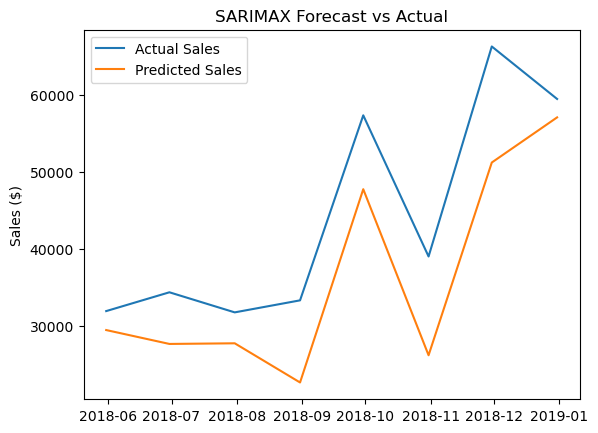

In [87]:
plt.plot(sarimax_test.index, sarimax_test['Sales'], label='Actual Sales')
plt.plot(sarimax_test.index, sarimax_pred, label='Predicted Sales')
plt.ylabel('Sales ($)')
plt.title('SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

In [89]:
sarimax_test['Sales'], sarimax_pred

(Order Date
 2018-05-31    31967.5794
 2018-06-30    34408.2347
 2018-07-31    31800.9025
 2018-08-31    33361.6780
 2018-09-30    57381.9420
 2018-10-31    39056.8857
 2018-11-30    66318.1870
 2018-12-31    59504.4808
 Freq: ME, Name: Sales, dtype: float64,
 2018-05-31    29505.9571
 2018-06-30    27703.3656
 2018-07-31    27786.2381
 2018-08-31    22700.5709
 2018-09-30    47790.4731
 2018-10-31    26235.6176
 2018-11-30    51254.0581
 2018-12-31    57112.9926
 Freq: ME, dtype: float64)

In [95]:
actual_sales = sarimax_test['Sales']
predicted_sales = sarimax_pred

rmse = root_mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)
mape = (abs((actual_sales - predicted_sales) / actual_sales)).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 9150.27
MAE: 7963.83
MAPE: 18.51%


### LSTM Model

In [ ]:
SEQ_LENGTH = 12  # Number of months (sequence length)

# Function to create sequences from data
def create_sequences(df, seq_length):
    data = df.values
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]  # Sequence of 12 months
        label = data[i+seq_length, df.columns.get_loc('Sales')]  # target column index
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Create sequences using your training and test DataFrames
X_train, y_train = create_sequences(lstm_train, SEQ_LENGTH)
X_test, y_test = create_sequences(lstm_test, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# For validation
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=17, hidden_layer_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # LSTM layer outputs (output, (hn, cn))
        lstm_out, _ = self.lstm(x)

        # Use the output of the last time step for prediction
        predictions = self.linear(lstm_out[:, -1])

        return predictions

In [ ]:
# Define training function for Ray Tune
# Define the training function for LSTM model
def train_lstm(config):
    hidden_layer_size = config["hidden_layer_size"]
    learning_rate = config["learning_rate"]
    epochs = config["epochs"]

    # Define the model
    model = LSTMModel(input_size=X_train.shape[2], hidden_layer_size=hidden_layer_size, output_size=1)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor.view(-1, 1))

        # Backward pass
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            tune.report(loss=loss.item())

# Define the search space for hyperparameters
search_space = {
    "hidden_layer_size": tune.choice([32, 64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "epochs": 100
}

In [ ]:
# Ray setup
ray.shutdown()  # Shutdown any previous Ray sessions
ray.init(ignore_reinit_error=True)

trainer = TorchTrainer(
    train_lstm,
    scaling_config=ray.train.ScalingConfig(num_workers=1),  # Adjust workers based on your system
    run_config=RunConfig(
        storage_path="~/ray_results",
        name="lstm_experiment",
        log_to_file=True,
        failure_config=FailureConfig(fail_fast=False),
    ),
    train_loop_config={},
    tune_config=tune.TuneConfig(
        search_space=search_space,
    ),
)

# Now, run the hyperparameter tuning with Ray Tune
result = trainer.fit()

# Access the best model
last_checkpoint = result.checkpoint

In [ ]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert predictions and actual values to numpy arrays
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test_np, label='Actual Sales')
plt.plot(y_pred_np, label='Predicted Sales')
plt.legend()
plt.title("LSTM Model Predictions vs Actual Sales")
plt.show()

In [ ]:
# 1) Standard library + ML imports
import os
import tempfile
import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 2) Ray imports
import ray
from ray import tune                                    
from ray.air import session, RunConfig
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

# 3) (Re)start Ray
ray.shutdown()
ray.init(ignore_reinit_error=True, logging_level="ERROR")

# 4) Your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.ReLU()  # Ensure non-negative predictions
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# 5) Data → PyTorch tensors (use your real DataFrames here)
SEQ_LENGTH = 12
def create_sequences(df, seq_length):
    data = df.values
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i+seq_length])
        y.append(data[i+seq_length, df.columns.get_loc('Log_Sales')])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(lstm_train, SEQ_LENGTH)
X_test,  y_test  = create_sequences(lstm_test,  SEQ_LENGTH)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor  = torch.Tensor(X_test)
y_test_tensor  = torch.Tensor(y_test).view(-1, 1)

# 6) Ray-compatible training fn
def train_lstm(config):
    model = LSTMModel(
        input_size  = X_train_tensor.shape[2],
        hidden_size = config["hidden_layer_size"],
    )
    loss_fn   = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    epochs    = config.get("epochs", 100)

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss  = loss_fn(preds, y_train_tensor)
        loss.backward()
        optimizer.step()

        # every 10 steps: report & checkpoint
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item():.6f}")
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(model.state_dict(), os.path.join(tmpdir, "model.pt"))
                session.report(
                    {"loss": loss.item()},
                    checkpoint=Checkpoint.from_directory(tmpdir)
                )

# 7) Define your hyperparameter space
search_space = {
    "hidden_layer_size": tune.choice([32, 64, 128, 256]),   # :contentReference[oaicite:0]{index=0}
    "learning_rate":     tune.loguniform(1e-4, 1e-2),       # :contentReference[oaicite:1]{index=1}
    "epochs":            100,
}

# 8) Scheduler (early-stop poorly performing trials)
scheduler = ASHAScheduler()

# 9) Launch the hyperparameter search
local_dir_path = pathlib.Path("./ray_results").resolve().as_uri()
tuner = tune.Tuner(
    train_lstm,
    tune_config = tune.TuneConfig(
        metric      = "loss",
        mode        = "min",
        num_samples = 10,
        scheduler   = scheduler,
        max_concurrent_trials=2,
    ),
    run_config = RunConfig(
    name        = "lstm_experiment",
    sync_config = None,
    log_to_file = False,      
    stop={"training_iteration": 100},
    storage_path   = local_dir_path,  
),
    param_space = search_space,
)

results = tuner.fit()

# 10) Grab best config & reload best model
best = results.get_best_result(metric="loss", mode="min")
print("Best hyperparameters:", best.config)

ckpt_dir = best.checkpoint.to_directory()
best_model = LSTMModel(
    input_size  = X_train_tensor.shape[2],
    hidden_size = best.config["hidden_layer_size"],
)
best_model.load_state_dict(torch.load(os.path.join(ckpt_dir, "model.pt")))

# 11) Evaluate on test set
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test_tensor).numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

import matplotlib.pyplot as plt
plt.plot(np.exp(y_true), label="Actual")
plt.plot(np.exp(y_pred), label="Predicted")
plt.legend()
plt.show()


In [99]:
lstm_test

,Year,Is Weekend,Sales,Category_Furniture,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos
Order Date,,,,,,,,,,
2018-07-20,1.0,0.0,43.0000,0.0,1.0,0.0,0.25,0.066987,0.277479,0.000000
2018-07-20,1.0,0.0,500.6405,0.0,1.0,0.0,0.25,0.066987,0.277479,0.000000
2018-07-21,1.0,1.0,101.9400,0.0,1.0,0.0,0.25,0.066987,0.000000,0.356896
2018-07-21,1.0,1.0,14.9400,0.0,1.0,0.0,0.25,0.066987,0.000000,0.356896
2018-07-21,1.0,1.0,2.8640,0.0,1.0,0.0,0.25,0.066987,0.000000,0.356896
...,...,...,...,...,...,...,...,...,...,...
2018-12-30,1.0,1.0,20.7200,0.0,1.0,0.0,0.50,1.000000,0.099031,0.801938
2018-12-30,1.0,1.0,323.1360,1.0,0.0,0.0,0.50,1.000000,0.099031,0.801938
2018-12-30,1.0,1.0,209.3000,0.0,1.0,0.0,0.50,1.000000,0.099031,0.801938


In [101]:
lstm_train.columns

Index(['Year', 'Is Weekend', 'Sales', 'Category_Furniture',
       'Category_Office Supplies', 'Category_Technology', 'Month_sin',
       'Month_cos', 'Weekday_sin', 'Weekday_cos'],
      dtype='object')

(train_lstm pid=20040) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=20040)   _log_deprecation_warning(
(train_lstm pid=20040) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=20040)   _log_deprecation_warning(
(train_lstm pid=20040) Checkpoint successfully created at: Checkpoi

(train_lstm pid=20040) Epoch 0: loss = 0.134604


(train_lstm pid=20316) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454 [repeated 7x across cluster]
(train_lstm pid=20316)   _log_deprecation_warning( [repeated 14x across cluster]
(train_lstm pid=20316) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0 [repeated 7x across cluster]
(train_lstm pid=20040) Checkpo

(train_lstm pid=20040) Epoch 10: loss = 0.117604 [repeated 8x across cluster]


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000001) [repeated 3x across cluster]


(train_lstm pid=6780) Epoch 10: loss = 0.116152 [repeated 3x across cluster]


(train_lstm pid=24424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00003_3_hidden_layer_size=32,learning_rate=0.0044_2025-05-02_15-37-12/checkpoint_000002) [repeated 4x across cluster]


(train_lstm pid=24424) Epoch 20: loss = 0.116321 [repeated 4x across cluster]


(train_lstm pid=23972) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=23972)   _log_deprecation_warning(
(train_lstm pid=23972) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=23972)   _log_deprecation_warning(
(train_lstm pid=23972) Checkpoint successfully created at: Checkpoi

(train_lstm pid=23972) Epoch 0: loss = 0.117295


(train_lstm pid=19260) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00008_8_hidden_layer_size=64,learning_rate=0.0024_2025-05-02_15-37-12/checkpoint_000000)


(train_lstm pid=19260) Epoch 0: loss = 0.119323
(train_lstm pid=23972) Epoch 10: loss = 0.116470 [repeated 6x across cluster]


(train_lstm pid=19260) C:\Users\justi\anaconda3\Lib\site-packages\ray\train\_internal\session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_lstm pid=19260)   _log_deprecation_warning( [repeated 2x across cluster]
(train_lstm pid=19260) C:\Users\justi\anaconda3\Lib\site-packages\ray\tune\trainable\trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_lstm pid=23972) Checkpoint successfully created at: Checkpoint(filesystem=local, p

(train_lstm pid=24188) Epoch 30: loss = 0.115510 [repeated 4x across cluster]


(train_lstm pid=24424) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00003_3_hidden_layer_size=32,learning_rate=0.0044_2025-05-02_15-37-12/checkpoint_000005) [repeated 5x across cluster]


(train_lstm pid=24424) Epoch 50: loss = 0.075334 [repeated 5x across cluster]


(train_lstm pid=23972) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00009_9_hidden_layer_size=32,learning_rate=0.0004_2025-05-02_15-37-12/checkpoint_000003)


(train_lstm pid=23972) Epoch 30: loss = 0.116057


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000004)


(train_lstm pid=6780) Epoch 40: loss = 0.088043


(raylet) [2025-05-02 15:38:36,965 E 20212 21908] (raylet.exe) worker_pool.cc:581: Some workers of the worker process(17172) have not registered within the timeout. The process is still alive, probably it's hanging during start.
(train_lstm pid=20040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00007_7_hidden_layer_size=32,learning_rate=0.0011_2025-05-02_15-37-12/checkpoint_000007) [repeated 4x across cluster]


(train_lstm pid=20040) Epoch 70: loss = 0.111572 [repeated 4x across cluster]


(train_lstm pid=20040) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00007_7_hidden_layer_size=32,learning_rate=0.0011_2025-05-02_15-37-12/checkpoint_000008) [repeated 4x across cluster]


(train_lstm pid=20040) Epoch 80: loss = 0.108261 [repeated 4x across cluster]


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000006) [repeated 3x across cluster]


(train_lstm pid=6780) Epoch 60: loss = 0.025094 [repeated 3x across cluster]


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000007) [repeated 4x across cluster]


(train_lstm pid=6780) Epoch 70: loss = 0.015349 [repeated 4x across cluster]


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000008)


(train_lstm pid=6780) Epoch 80: loss = 0.010540


(train_lstm pid=6780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/justi/Documents/Springboard/Capstones/Capstone 2/ray_results/lstm_experiment/train_lstm_d7d34_00001_1_hidden_layer_size=64,learning_rate=0.0029_2025-05-02_15-37-12/checkpoint_000009)


(train_lstm pid=6780) Epoch 90: loss = 0.008839
Best hyperparameters: {'hidden_layer_size': 64, 'learning_rate': 0.0028647857256497594, 'epochs': 100}


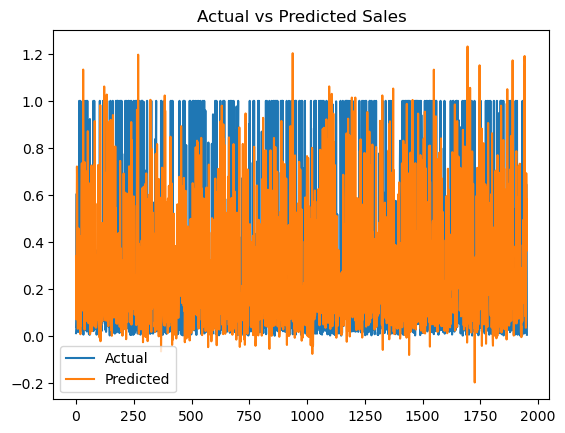

In [199]:
# 1) Standard library + ML imports
import os
import tempfile
import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 2) Ray imports
import ray
from ray import tune                                    
from ray.air import session, RunConfig
from ray.train import Checkpoint
from ray.tune.tune_config import TuneConfig
from ray.tune.schedulers import ASHAScheduler

# 3) (Re)start Ray
ray.shutdown()
ray.init(ignore_reinit_error=True, logging_level="ERROR")

# 4) Updated LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# 5) Create sequences (includes Log_Sales as a feature now)
SEQ_LENGTH = 7
def create_sequences(df, seq_length):
    """
    Create sequences using all features (including Sales).
    Target remains the 'Sales' of the next time step.
    """
    X, y = [], []
    features = df.values
    for i in range(len(df) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(features[i+seq_length][df.columns.get_loc('Sales')])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(lstm_train, SEQ_LENGTH)
X_test, y_test = create_sequences(lstm_test, SEQ_LENGTH)

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).view(-1, 1)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test).view(-1, 1)

# 6) Training function for Ray Tune
def train_lstm(config):
    model = LSTMModel(
        input_size  = X_train_tensor.shape[2],
        hidden_size = config["hidden_layer_size"],
    )
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    epochs = config.get("epochs", 100)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {avg_loss:.6f}")
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(model.state_dict(), os.path.join(tmpdir, "model.pt"))
                session.report(
                    {"loss": avg_loss},
                    checkpoint=Checkpoint.from_directory(tmpdir)
                )

# 7) Search space and scheduler
search_space = {
    "hidden_layer_size": tune.choice([32, 64]),
    "learning_rate": tune.loguniform(1e-4, 5e-3),
    "epochs": 100,
}
scheduler = ASHAScheduler()

# 8) RunConfig and TuneConfig
trainable = tune.with_resources(train_lstm, {"cpu": 1})
run_cfg = RunConfig(
    name="lstm_experiment",
    stop={"training_iteration": 100},
    storage_path=str(pathlib.Path("./ray_results").resolve()),
    sync_config=None,
    log_to_file=False
)
tune_cfg = TuneConfig(
    metric="loss",
    mode="min",
    num_samples=10,
    scheduler=scheduler
)

# 9) Run the tuner
tuner = tune.Tuner(
    trainable,
    run_config=run_cfg,
    tune_config=tune_cfg,
    param_space=search_space
)
results = tuner.fit()

# 10) Load best model and evaluate
best = results.get_best_result(metric="loss", mode="min")
print("Best hyperparameters:", best.config)
ckpt_dir = best.checkpoint.to_directory()

best_model = LSTMModel(
    input_size=X_train_tensor.shape[2],
    hidden_size=best.config["hidden_layer_size"]
)
best_model.load_state_dict(torch.load(os.path.join(ckpt_dir, "model.pt")))

# 11) Predictions and plot
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test_tensor).numpy().flatten()
    y_true = y_test_tensor.numpy().flatten()

plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()


In [201]:
y_pred.min(), y_pred.max()

(-0.19769165, 1.23117)

In [203]:
y_true.min(), y_true.max()

(0.0010915711, 1.0)

In [205]:
for i in range(50):
    print(f"True: {y_true[i]:.4f}, Predicted: {y_pred[i]:.4f}")

True: 0.0121, Predicted: 0.3399
True: 0.0318, Predicted: 0.0708
True: 0.4495, Predicted: 0.2884
True: 0.6048, Predicted: 0.4994
True: 0.0341, Predicted: 0.7208
True: 0.0998, Predicted: 0.6431
True: 0.0669, Predicted: 0.3426
True: 0.4624, Predicted: 0.1371
True: 0.0385, Predicted: 0.0307
True: 0.0167, Predicted: 0.3209
True: 0.5428, Predicted: 0.1678
True: 0.4201, Predicted: 0.4572
True: 0.1874, Predicted: 0.0906
True: 0.0511, Predicted: 0.0609
True: 1.0000, Predicted: 0.1838
True: 0.2478, Predicted: 0.0663
True: 0.1429, Predicted: 0.1342
True: 0.0590, Predicted: 0.3518
True: 1.0000, Predicted: 0.0359
True: 0.2421, Predicted: 0.0073
True: 0.0269, Predicted: 0.0593
True: 0.1257, Predicted: 0.0442
True: 0.3185, Predicted: 0.4241
True: 0.1157, Predicted: 0.2155
True: 0.0225, Predicted: 0.5947
True: 0.0295, Predicted: 0.7344
True: 0.0819, Predicted: 0.1336
True: 0.0254, Predicted: 0.1083
True: 0.7987, Predicted: 0.1430
True: 1.0000, Predicted: 0.4869
True: 0.0393, Predicted: 0.5766
True: 0.

In [207]:
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = (abs((y_true - y_pred) / y_true)).mean() * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 0.42
MAE: 0.31
MAPE: 690.87%
